# 제4 고지 : 신경망 만들기 
## STEP 44 : 매개변수를 모아두는 계층

이전 단계에서 확장한 '신경망'으로 이제 DeZero를 '신경망 프레임워크'라고 말할 수 있다. 하지만 아직 '사용 편의성' 면에서는 몇가지 문제가 있다. 
특히 이번 단계에서는 **매개변수**에 대해 다루는데, 이전 단계에서는 매개변수의 기울기를 재설정하거나 갱신할때 다소 단조로운 코드를 작성했다. 
하지만 앞으로 더욱 복잡한 신경망을 다루게 된다면 매개변수를 다루는일도 그만큼 복잡해진다.  
따라서 이번 단계에서는 **매개변수를 담는 구조**를 `Parameter` 와 `Layer` 라는 클래스로 구현한다. 이 **두 클래스를 사용하여 매개변수 관리를 자동화 하는 것이 목적**이다.

### 44.1 Parameter 클래스 구현 
```python
class Parameter(Variable):
    pass
```
`Variable` 클래스를 상속하고, 동일한 기능을 가진다.  
즉, 아래와 같이 `Paramter` 와 `Variable` 조합으로 계산할수 있고 동일한 기능을 가지지만, 두 인스턴스를 구분할 수 있다.

In [2]:
import sys
sys.path.append("..")

import numpy as np 
from dezero import Variable,Parameter

x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p,Parameter))
print(isinstance(x,Parameter))
print(isinstance(y,Parameter))

True
False
False


### 44.2 Layer 클래스 구현
```python
class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name,value):
        if isinstance(value,Parameter):
            self._params.add(name)
        super().__setattr__(name,value)

```
이번에 구현할 `Linear` 클래스는 `Function` 클래스와 마찬가지로, 변수를 변환하는 클래스이다. 그러나 **매개변수를 유지**한다는점이 다르다.

<span style='background-color : #ffdce0'>💡<b>`Linear` 클래스를 기반 클래스로 두고 구체적인 변환은 자식 클래스에서 구현한다.</b></span>

여기서 주목해야할 것은 

1. `_params` 라는 인스턴스 변수에 `Layer`에 속한 매개변수를 관리한다는 것
2. `__setattr__` 은 이름이 `name`인 인스턴스 변수 값으로 `value`를 전달하는 함수로 해당함수를 오버라이딩 하면 인스턴수 변수를 설정할때 자신만의 로직 추가 가능하다는것

이다.

구체적으로 살펴보면, 
- `value`가 `Parameter` 인스턴스라면 `self._params` 에 `name`을 추가한다. 그리고 인스턴스 변수 `__dict__` 에는 모든 인스턴스 변수가 딕셔너리 타입으로 저장되기 때문에  `Parameter` 변수만 꺼낼수도 있다.

<span style='background-color : #ffdce0'>💡<b> `self._params`에 `value`가 아닌 `name`을 추가하는데, 매개변수를 외부파일로 저장할때, `name` 을 유지하는 쪽이 편리하기 때문이다. 이는 53단계에서 살펴본다.</b></span>

In [4]:
class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name,value):
        if isinstance(value,Parameter):
            self._params.add(name)
        super().__setattr__(name,value)
        
layer = Layer()
layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))
layer.p4 = "test" # parameter가 아닌 값

print(layer._params)
print("-----------------")

for name in layer._params:
    print(name,layer.__dict__[name])

{'p2', 'p1', 'p3'}
-----------------
p2 variable(2)
p1 variable(1)
p3 variable(3)


```python
import weakref
class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
        super().__setattr__(name, value)

    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, inputs):
        raise NotImplementedError()

    def params(self):
        for name in self._params:
            yield self.__dict__[name]

    def cleargrads(self):
        for param in self.params():
            param.cleargrad()
```

추가적으로 4개의 메서드를 구현한다.

1. `__call__()` :  입력받은 인수를 건네 `forward` 메서드를 호출하고, 출력이 `tuple` 이 아니라면 `tuple` 로 변환한다. 또한 나중을 생각하여 입력과 출력을 약한 참조로 유지한다.
2. `forward()` : 자식 클래스에서 구현한다.
3. `params()` : `Layer` 인스턴스에 담겨 있는 `Parameter` 인스턴스들을 꺼낸다.
4. `cleargrads()` : `Layer` 가 가진 모든 매개변수에 대해 `cleargrad`를 호출한다.


### 44.3 Linear 클래스 구현 
이어서 선형변환을 하는 `Linear` 클래스를 구현한다.(이는 함수로서의 `Linear` 클래스가 아닌 **계층으로서의 `Linear` 클래스**다)

```python
class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if self.in_size is not None: # in_size가 지정되어 있지 않다면 나중으로 연기
            self._init_W()

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I) # efficient backprop. in neural networks tricks of the trade
        self.W.data = W_data

    def forward(self, x):
        # 데이터를 흘려보내는 시점에 가중치 초기화
        if self.W.data is None:
            self.in_size = x.shape[1]
            self._init_W()

        y = F.linear(x, self.W, self.b)
        return y
```
여기서 주목해야 할 것은 

1. 가중치 $W$를 생성하는 시점을 `forward()` 메서드에서 생성하도록 시점을 늦췄다.
2. 이로 인해 사용자가 입력 크기(`in_size`) 를 지정하지 않아도 **자동으로 결정가능**하다. 

### 44.4 Layer를 이용한 신경망 구현

이제 `Linear` 클래스를 활용하여 신경망을 구현해보자.

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126017)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355146)
variable(0.07655073683421637)
variable(0.07637803086238222)
variable(0.07618764131185564)


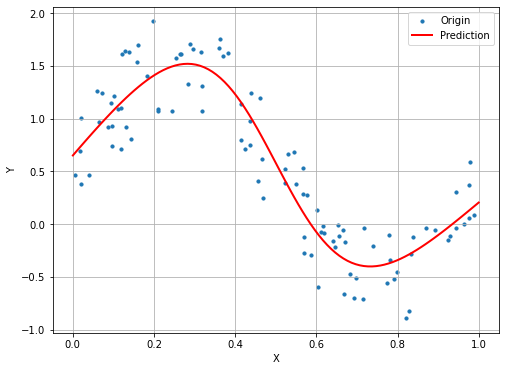

In [1]:
import sys
sys.path.append("..")

import numpy as np 
from dezero import Variable
import dezero.functions as F 
import dezero.layers as L 

# 토이 데이터셋
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 *np.pi *x) + np.random.rand(100,1) #  데이터 생성에 sin 함수 이용


##########################
l1 = L.Linear(10) #  출력 크기 지정
l2 = L.Linear(1)
##########################

# 2. 신경망 추론
def predict(x):
    y= l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y 

# 3. 신경망 학습
lr = 0.2
iters = 10000 
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y,y_pred)
    
    ##########################
    l1.cleargrads()
    l2.cleargrads()
    ##########################
    loss.backward()

    ##########################
    for l in [l1,l2]:
        for p in l.params():
            p.data -= lr*p.grad.data 
            
    ##########################    
    if i % 1000 == 0:
        print(loss)
        
    
# 그래프로 시각화
import matplotlib.pyplot as plt
x_test = np.linspace(0, 1, 100).reshape(100,1)
y_pred = predict(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Origin', s=10)
plt.plot(x_test, y_pred.data, label='Prediction', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()